In [1]:
from spec_exam import Gen_spec
from spec_extract import Scale_model, Box_phot
from astropy.table import Table
import pandas as pd
from scipy.interpolate import interp1d, interp2d
from glob import glob
from spec_tools import Source_present, Smooth, Median_w_Error_cont
from grizli import multifit
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sea
import os
import numpy as np
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
speclist = glob('../spec_files/*g102*')

In [3]:
id_list = np.array([int(U.split('_')[2]) for U in speclist])

In [4]:
f_list = np.array([U.split('_')[1].split('/')[1] for U in speclist])

In [182]:
id_list[34]

28070

<Figure size 1080x576 with 0 Axes>

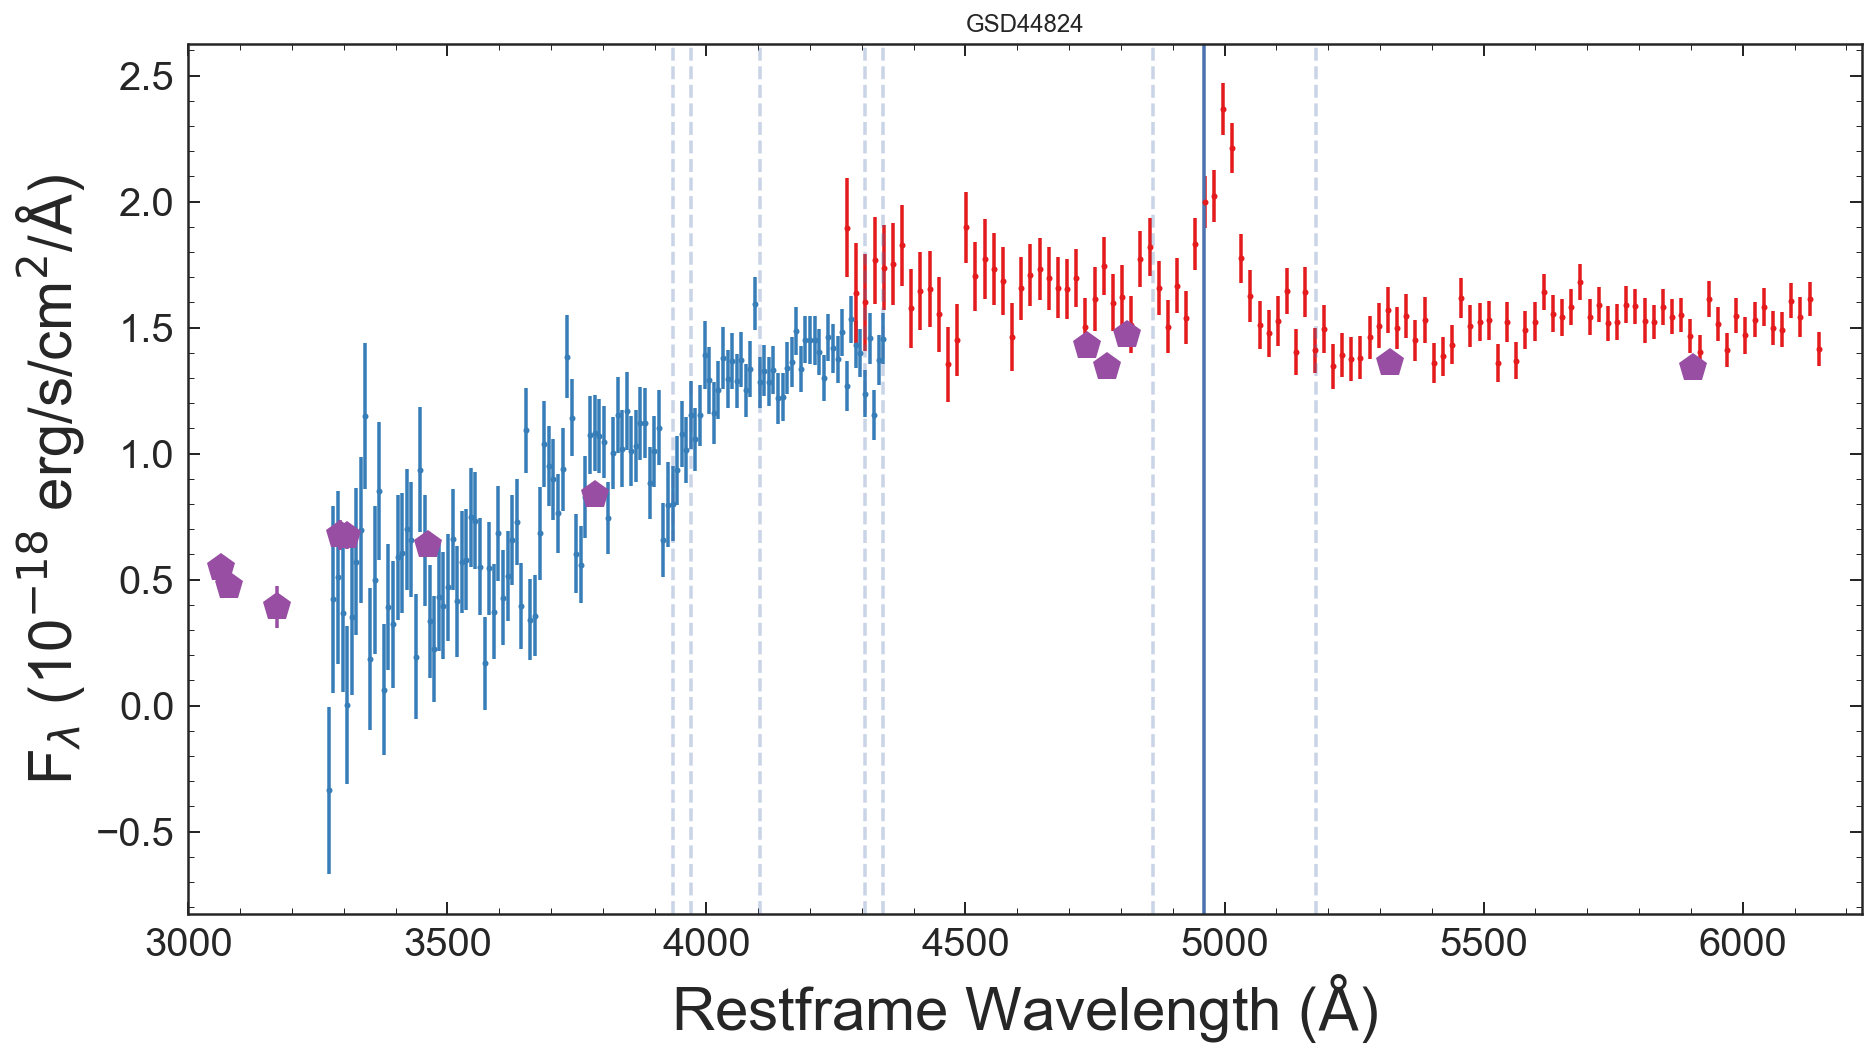

In [336]:
idx = 52

sp = Gen_spec(f_list[idx],id_list[idx],1, 
              glob('../beams/*{0}*.g102.A.fits'.format(id_list[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(id_list[idx]))[0], g102_lims=[8500,11300] )

plt.figure(figsize=[15,8])
plt.rcParams["figure.figsize"] = (15,8)

# These are in unitless percentages of the figure size. (0,0 is bottom left)
fig,ax1 = plt.subplots()
left, bottom, width, height = [0.45, 0.17, 0.4, 0.3]

rshift = 1.6

ax1.errorbar(sp.Bwv /(1 + rshift),sp.Bflx*1E18,sp.Berr*1E18,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
ax1.errorbar(sp.Rwv /(1 + rshift),sp.Rflx*1E18,sp.Rerr*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
ax1.errorbar(sp.Pwv /(1 + rshift),sp.Pflx*1E18,sp.Perr*1E18,
                             linestyle='None', marker='p', markersize=15, color='#984ea3')

plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)

plt.axvline(4960)
plt.axvline(6564)

# ax1.set_ylim(-.3,1.4)
ax1.set_xlim(7800/(1 + rshift),16200 /(1 + rshift))
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.title(f_list[idx] + '{0}'.format(id_list[idx]))
plt.tick_params(axis='both', which='major', labelsize=20)

# ax2 = fig.add_axes([left, bottom, width, height])
# ax2.errorbar(np.log10(sp.Bwv),sp.Bflx*1E18,sp.Berr*1E18,
#             linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
# ax2.errorbar(np.log10(sp.Rwv),sp.Rflx*1E18,sp.Rerr*1E18,
#             linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

# ax2.errorbar(np.log10(sp.Pwv),sp.Pflx*1E18,sp.Perr*1E18,
#                              linestyle='None', marker='p', markersize=10, color='#984ea3')

# plt.xticks(np.log10([2500,5000,7500,10000,25000,50000,75000,100000]),[2500,5000,7500,10000,25000,50000,75000,100000])
# ax2.minorticks_off()
# # ax2.set_ylim(-.1,1.4)
# ax2.set_xlim(np.log10(3000),np.log10(100000))

badlist = gnd14140, gnd38061, gsd25294, gsd25546,gsd28070

# gen mask

In [343]:
'../spec_files/spec_mask/GND_10445_g102_mask.npy'

58

In [342]:
idx = 58

Bwv, Bflx, Berr, Bflt = np.load('../spec_files/{0}_{1}_g102.npy'.format(f_list[idx],id_list[idx]))
Rwv, Rflx, Rerr, Rflt = np.load('../spec_files/{0}_{1}_g141.npy'.format(f_list[idx],id_list[idx]))
Pwv, Pflx, Perr, Pnum = np.load('../phot/{0}_{1}_phot.npy'.format(f_list[idx],id_list[idx]))

print(SN(Bwv, Bflx, Berr, min(Bwv), max(Bwv)))
print(SN(Rwv, Rflx, Rerr, min(Rwv), max(Rwv)))

Bmask = np.repeat(True,len(Bwv))
Rmask = np.repeat(True,len(Rwv))

gs= GridSpec(1,3)

plt.figure(figsize=[20,6])
plt.subplot(gs[0])
plt.errorbar(Bwv,Bflx*1E18,Berr*1E18,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv,Rflx*1E18,Rerr*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.errorbar(Pwv,Pflx*1E18,Perr*1E18,
                             linestyle='None', marker='p', markersize=15, color='#984ea3')

plt.xlim(7800,16200)
plt.ylabel('F$_\lambda$ (10$^{-18}$ erg/s/cm$^2$/$\\rm \AA$)',size=30)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.title(f_list[idx] + '{0}'.format(id_list[idx]))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-1,3)

plt.subplot(gs[1])
plt.plot(Bwv,Bflx / Berr, color='#377eb8')
plt.errorbar(Rwv,Rflx / Rerr, color='#e41a1c')
plt.axvspan(11000,14000,alpha=0.3)

plt.xlim(7800,16200)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.title(f_list[idx] + '{0}'.format(id_list[idx]))
plt.tick_params(axis='both', which='major', labelsize=20)

# for i in range(len(Rmask)):
#     if 10000 < Rwv[i] < 14000:
#         Rmask[i] = False



plt.subplot(gs[2])
plt.errorbar(Bwv[Bmask],Bflx[Bmask]*1E18,Berr[Bmask]*1E18,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[Rmask],Rflx[Rmask]*1E18,Rerr[Rmask]*1E18,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.xlim(7800,16200)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=30)
plt.title(f_list[idx] + '{0}'.format(id_list[idx]))
plt.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-1,3)

np.save('../spec_files/spec_mask/{0}_{1}_g102_mask'.format(f_list[idx],id_list[idx]), Bmask)
np.save('../spec_files/spec_mask/{0}_{1}_g141_mask'.format(f_list[idx],id_list[idx]), Rmask)


IndexError: index 58 is out of bounds for axis 0 with size 58

In [245]:
for i in range(len(Bmask)):
    if 11200 < Bwv[i] < 11700:
       print('False')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [5]:
def Scale_spectra(bwv,bfl,ber,rwv,rfl,rer,pwv,pfl):
    Bp = []; Bs = []; Bsig = []
    Rp = [] ; Rs = []; Rsig = []

    IDb = [U for U in range(len(bwv)) if bfl[U]**2 > 0] 
    IDr = [U for U in range(len(rwv)) if rfl[U]**2 > 0] 
    
    for i in range(len(pwv)):
        if (min(bwv[IDb]) < pwv[i] - 150) and (max(bwv[IDb]) > pwv[i] + 150):
            eff_wv, phot, phot_er = Box_phot(bwv[IDb],Smooth(bfl[IDb],bwv[IDb]),ber[IDb], pwv[i])
            Bp.append(pfl[i]); Bs.append(phot); Bsig.append(phot_er)

        if (min(rwv[IDr]) < pwv[i] - 150) and (max(rwv[IDr]) > pwv[i] + 150):
            eff_wv, phot, phot_er = Box_phot(rwv[IDr],Smooth(rfl[IDr],rwv[IDr]),rer[IDr], pwv[i])
            Rp.append(pfl[i]); Rs.append(phot); Rsig.append(phot_er)

    bscale = Scale_model(np.array(Bs), np.array(Bsig), np.array(Bp))
    rscale = Scale_model(np.array(Rs), np.array(Rsig), np.array(Rp))    
    print(Bs,Rs)
    print(Bp,Rp)
    
    return bfl / bscale, ber / bscale, rfl / rscale, rer / rscale

def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SN(w, f, e, wmin, wmax):
#     wv = wv[fl**2 > 0]
#     er = er[fl**2 > 0]
#     fl = fl[fl**2 > 0]
    
    IDx = [U for U in range(len(w)) if wmin < w[U] < wmax]
    
    return np.trapz(f[IDx])/ Sig_int(e[IDx])

def SN_full(Bw, Bf, Be, Rw, Rf, Re, Bmin, Bmax, Rmin, Rmax):
#     wv = wv[fl**2 > 0]
#     er = er[fl**2 > 0]
#     fl = fl[fl**2 > 0]
    
    IDb = [U for U in range(len(Bw)) if Bmin < Bw[U] < Bmax]
    IDr = [U for U in range(len(Rw)) if Rmin < Rw[U] < Rmax]
    
    return np.trapz(np.append(Bf[IDb],Rf[IDr]))/ Sig_int(np.append(Be[IDb],Re[IDr]))

In [12]:
gids = []
gfld = []

u=0
for i in range(len(id_list)):
    idx = i
    sp = Gen_spec(f_list[idx],id_list[idx],1, 
                  glob('../beams/*{0}*.g102.A.fits'.format(id_list[idx]))[0],
                  glob('../beams/*{0}*.g141.A.fits'.format(id_list[idx]))[0], g102_lims=[8500,11300] )

#     print(id_list[idx])
#     print(SN(sp.Bwv, sp.Bflx, sp.Berr, min(sp.Bwv), max(sp.Bwv)))
#     print(SN(sp.Rwv, sp.Rflx, sp.Rerr, min(sp.Rwv), max(sp.Rwv)))
    sn = SN_full(sp.Bwv, sp.Bflx, sp.Berr,sp.Rwv, sp.Rflx, sp.Rerr, min(sp.Bwv), max(sp.Bwv),min(sp.Rwv), max(sp.Rwv))
    if sn > 1:
        gids.append(id_list[idx])
        gfld.append(f_list[idx])
        print(sn)
        print('--')
        u+=1
print(u)

1.6871200418356382
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5.385918028991855
--
1.1066188247807907
--
5.498967742989618
--
3.060329309716393
--
3.4875011170016728
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


7.194546529446183
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1.922299198282001
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


8.250111775802786
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


6.219642383695541
--
1.4249954978546686
--
2.2876737374524074
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


4.48256070942747
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


1.7939967279263667
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2.483645474473449
--
8.555292747543122
--
4.362910280025986
--
5.7250250695190426
--
19.066747032172746
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


3.6794535593664026
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


8.109851684506424
--
8.892031753645977
--
11.709019926798318
--
3.5082622764831415
--
5.806966896729762
--
14.217438358640639
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


5.577522551803892
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


3.393462626826624
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


2.962428981690405
--
14.185581051217307
--
13.027142516262536
--
1.2061817019691128
--
5.466155931836237
--
1.3276303274565826
--


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


3.496411982088019
--
35


In [31]:
galDB = pd.DataFrame({ 'ids' : gids, 'field': gfld})

In [2]:
# galDB.to_pickle('../dataframes/galaxy_database.pkl')
galDB = pd.read_pickle('../dataframes/galaxy_database.pkl')

In [249]:
from spec_tools import Source_present, Photometry, Scale_model, Oldest_galaxy
data_path = '../data/'
model_path = hpath + 'fsps_models_for_fit/fsps_spec/'
chi_path = '../chidat/'
spec_path = '../spec_files/'
beam_path = '../beams/'
template_path = '../templates/'
out_path = '../data/posteriors/'
phot_path = '../phot/'

def Scale_model_mult(D, sig, M):
    C = np.sum(((D * M) / sig ** 2), axis=1) / np.sum((M ** 2 / sig ** 2), axis=1)
    return C

def Resize_and_fit(fit_wv, fit_fl, fit_er, fit_flat, mwv, mfl, metal, age, tau, rshift):
    mfl = np.ma.masked_invalid(mfl)
    mfl.data[mfl.mask] = 0
    mfl = interp2d(mwv,range(len(mfl.data)),mfl.data)(fit_wv,range(len(mfl.data)))
    mfl = mfl / fit_flat
    SCL = Scale_model_mult(fit_fl,fit_er,mfl)
    return np.sum(((fit_fl - np.array([SCL]).T*mfl) / fit_er) ** 2, axis=1).reshape([len(metal), len(age), len(tau), len(rshift)])

def Analyze_rshift(chi, metal, age, tau, rshift):
    ####### Get scaling factor for tau reshaping
    ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

    ######## get Pd and Pz 
    P_full = np.exp(- chi / 2).astype(np.float128)

    Pz = np.trapz(np.trapz(np.trapz(P_full.T, metal, axis=3), age, axis=2), ultau, axis=1) / \
         np.trapz(np.trapz(np.trapz(np.trapz(P_full.T, metal, axis=3), age, axis=2), ultau, axis=1),rshift)

    return Pz

def Fit_rshift(field, galaxy, g102_beam, g141_beam, metal, age, tau, rshift, errterm = 0):
    ######## initialize spec
    sp = Gen_spec(field, galaxy, 1, g102_beam, g141_beam, g102_lims=[8500,11300], phot_tmp_err = True, errterm = errterm)
    
    wv,fl = np.load(model_path + 'm0.019_a2.8_dt0_spec.npy')
    [Bmwv,Bmf_len], [Rmwv,Rmf_len] = sp.Sim_spec_mult(wv,fl)
    
    ##### set model wave
    Bmfl = np.zeros([len(metal)*len(age)*len(tau)*len(rshift),len(Bmf_len)])
    Rmfl = np.zeros([len(metal)*len(age)*len(tau)*len(rshift),len(Rmf_len)])
    Pmfl = np.zeros([len(metal)*len(age)*len(tau)*len(rshift),len(sp.IDP)])
    
    for i in range(len(metal)):
        for ii in range(len(age)):
            for iii in range(len(tau)):
                wv,fl = np.load(model_path + 'm{0}_a{1}_dt{2}_spec.npy'.format(metal[i], age[ii], tau[iii]))
                for iv in range(len(rshift)):
                    [Bmwv,Bmflx], [Rmwv,Rmflx] = sp.Sim_spec_mult(wv * (1 + rshift[iv]),fl)
                    Pmwv, Pmflx = sp.Sim_phot_mult(wv * (1 + rshift[iv]),fl)
                                      
                    Bmfl[i*len(age)*len(tau)*len(rshift) + ii*len(tau)*len(rshift) + iii*len(rshift) + iv] = Bmflx
                    Rmfl[i*len(age)*len(tau)*len(rshift) + ii*len(tau)*len(rshift) + iii*len(rshift) + iv] = Rmflx
                    Pmfl[i*len(age)*len(tau)*len(rshift) + ii*len(tau)*len(rshift) + iii*len(rshift) + iv] = Pmflx

    ## set some variables
    wv,fl = np.load(model_path + 'm0.019_a2.0_dt8.0_spec.npy')
    [Bmwv,Bmflx], [Rmwv,Rmflx] = sp.Sim_spec_mult(wv,fl)
    
    Bchi = Resize_and_fit(sp.Bwv, sp.Bflx, sp.Berr, sp.Bflt, Bmwv, Bmfl, metal, age, tau, rshift)
    Rchi = Resize_and_fit(sp.Rwv, sp.Rflx, sp.Rerr, sp.Rflt, Rmwv, Rmfl, metal, age, tau, rshift)
        
    SCL = Scale_model_mult(sp.Pflx, sp.Perr, Pmfl)
    Pchi = np.sum(((sp.Pflx - np.array([SCL]).T*Pmfl) / sp.Perr) ** 2, axis=1).reshape([len(metal), len(age), len(tau), len(rshift)])
    
    Achi = Bchi + Rchi + Pchi
    
    Pz = Analyze_rshift(Achi, metal, age, tau, rshift)
    Pzb = Analyze_rshift(Bchi, metal, age, tau, rshift)
    Pzr = Analyze_rshift(Rchi, metal, age, tau, rshift)
    Pzp = Analyze_rshift(Pchi, metal, age, tau, rshift)
    
#     print(np.argwhere(Achi == np.min(Achi)))
#     print(np.argwhere(Bchi == np.min(Bchi)))
#     print(np.argwhere(Rchi == np.min(Rchi)))
#     print(np.argwhere(Pchi == np.min(Pchi)))
    
    np.save(out_path + '{0}_{1}_rs_lres_pos'.format(field, galaxy),[rshift, Pz, Pzb, Pzr, Pzp])
#     return rshift, Pz, Pzb, Pzr, Pzp

In [221]:
z = np.arange(1.3,3.5,0.01)
# mtest = [0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028]
# atest = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5]
# # ttest=[0, 8.48, 8.78, 8.95, 9.08, 9.18, 9.26, 9.32, 9.38, 9.43, 9.48]
ttest=[0, 8.95, 9.26, 9.43]

metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,4.6,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]

idx = 24
z, Pz, Pzb, Pzr, Pzp = Fit_rshift(galDB.field[idx], galDB.ids[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
          glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],metal, age, ttest, z)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


[[ 0  5  0 87]]
[[ 1  1  0 10]]
[[ 10  15   0 173]]
[[ 6 40  1 33]]


In [233]:
print(metal[4],age[40],ttest[1],z[33])

0.006 4.5 8.95 1.6300000000000003


In [236]:
galDB.ids[idx]

41886

[2.17]


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


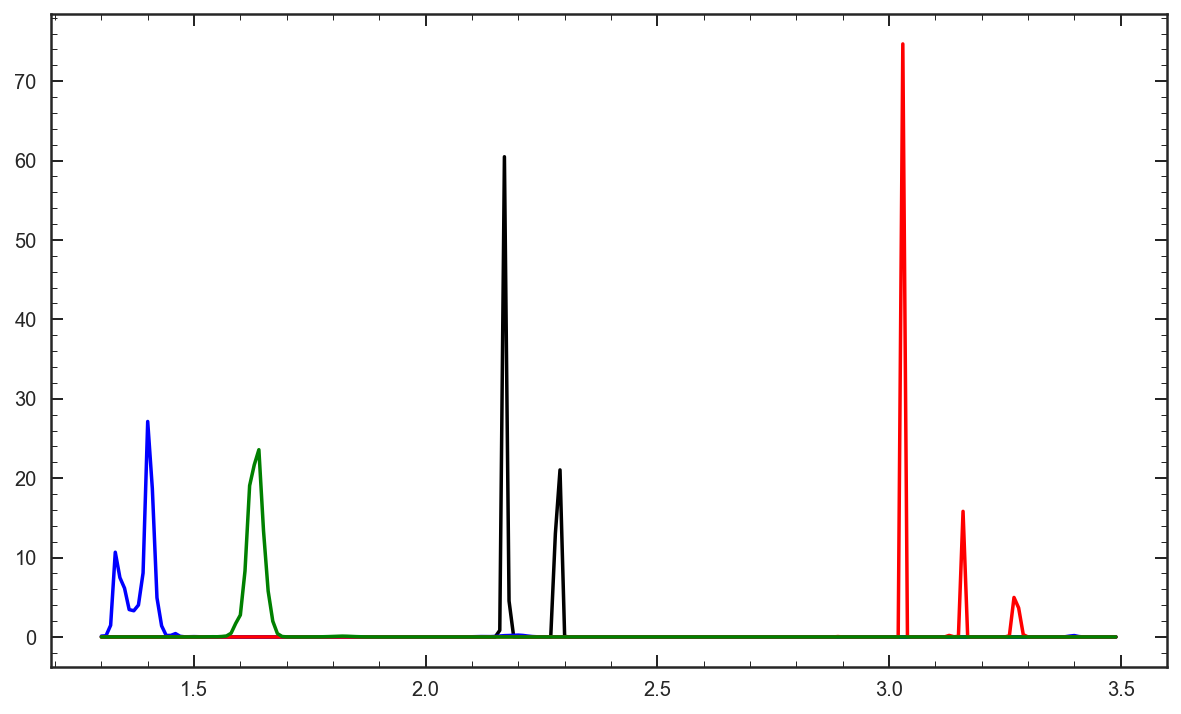

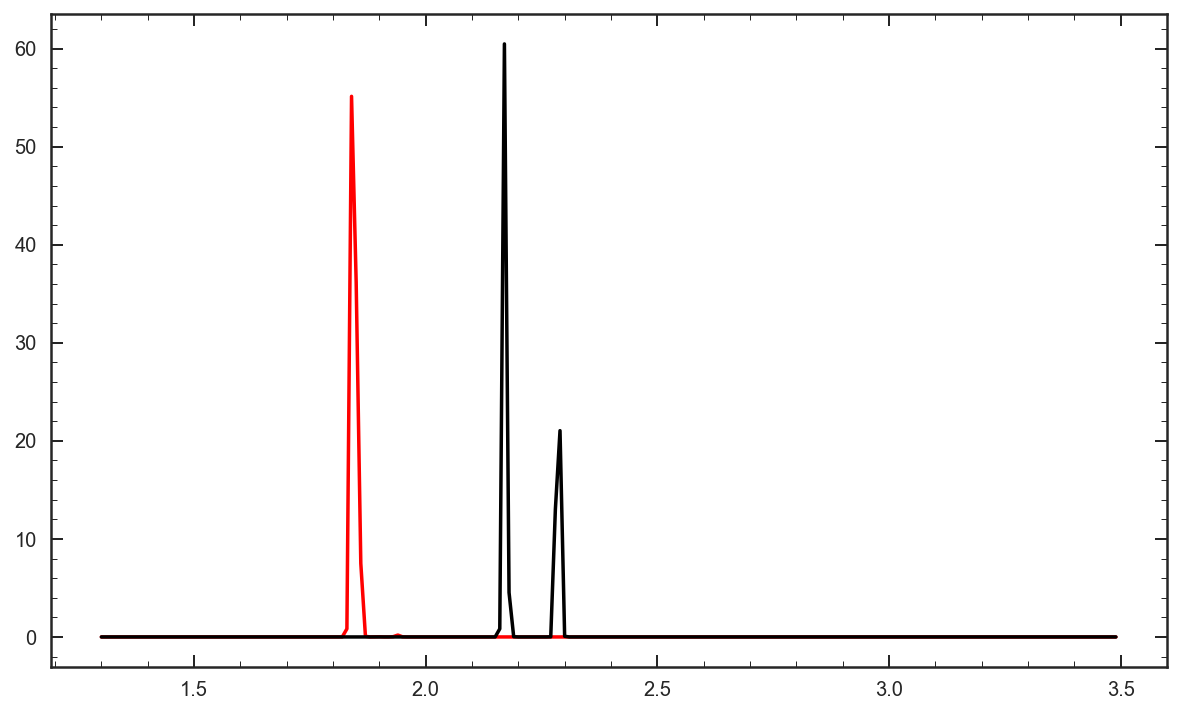

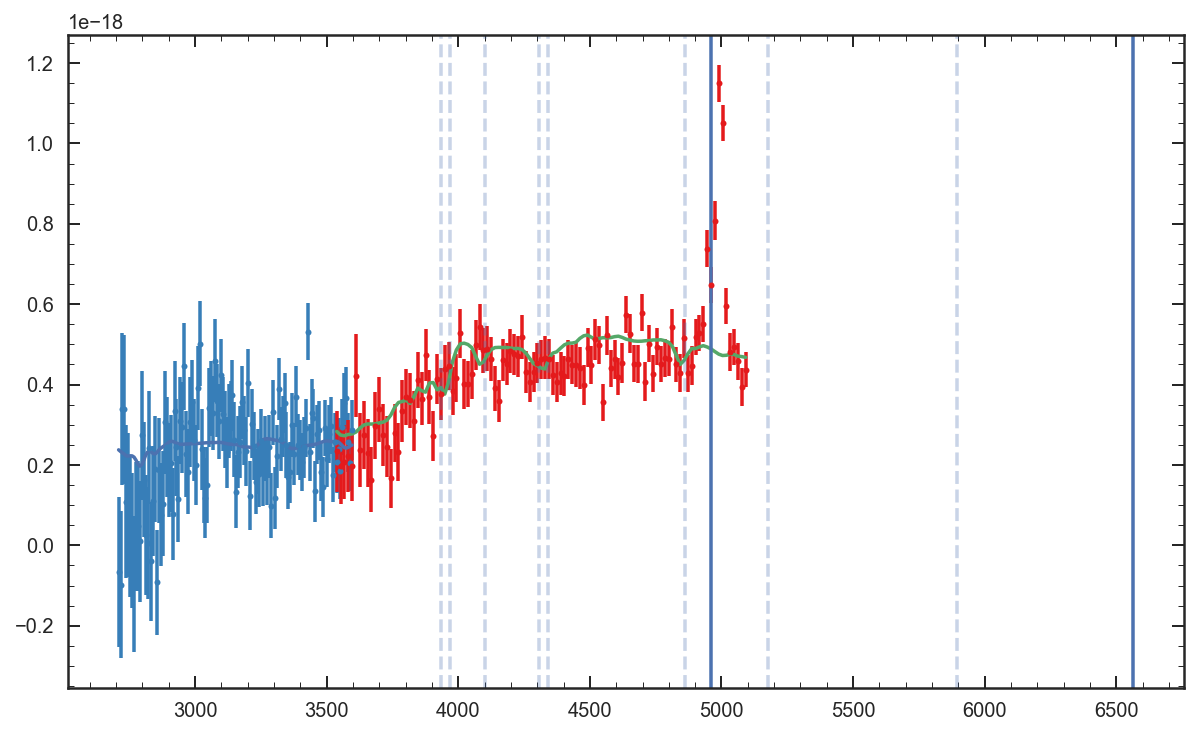

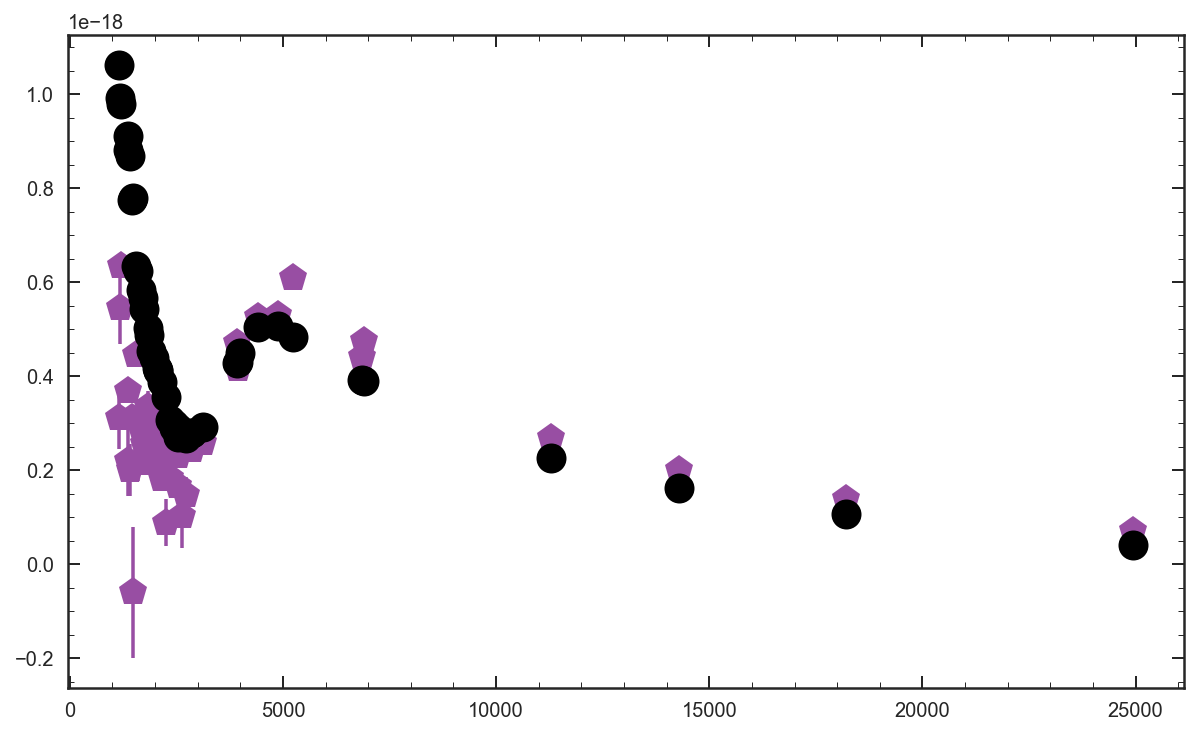

In [246]:
plt.figure(figsize=[10,6])
plt.plot(z,Pz/ np.trapz(Pz,z),'k')
plt.plot(z,Pzb/ np.trapz(Pzb,z),'b')
plt.plot(z,Pzr/ np.trapz(Pzr,z),'r')
plt.plot(z,Pzp/ np.trapz(Pzp,z),'g')

plt.figure(figsize=[10,6])
plt.plot(z,Pzb*Pzr*Pzp / np.trapz(Pzb*Pzr*Pzp,z),'r')
plt.plot(z,Pz / np.trapz(Pz,z),'k')


print(z[Pz == max(Pz)])

zfit = z[Pz == max(Pz)][0]
zfitb = z[Pzb == max(Pzb)][0]
zfitr = z[Pzr == max(Pzr)][0]
zfitp = z[Pzp == max(Pzp)][0]

sp = Gen_spec(galDB.field[idx], galDB.ids[idx], 2.1386,glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300] )
sp.Sim_all(0.006,4.5,8.95)
        
plt.figure(figsize=[10,6])
plt.errorbar(sp.Bwv_rf, sp.Bflx, sp.Berr,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(sp.Bwv_rf, sp.Bmfl)

plt.errorbar(sp.Rwv_rf, sp.Rflx, sp.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(sp.Rwv_rf, sp.Rmfl)

plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)

plt.axvline(4960)
plt.axvline(6564)

plt.figure(figsize=[10,6])
plt.errorbar(sp.Pwv_rf, sp.Pflx, sp.Perr,
                             linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(sp.Pwv_rf, sp.Pmfl,'ko',zorder=5,ms=15)

In [251]:
z = np.arange(1.3,3.5,0.01)
ttest=[0, 8.95, 9.26, 9.43]
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,4.6,.1),1)

for i in galDB.index:
    idx = i
    print(galDB.ids[idx])
    Fit_rshift(galDB.field[idx], galDB.ids[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],metal, age, ttest, z)

15976


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


KeyboardInterrupt: 

In [163]:
x=np.random.rand(3,4,5)

In [168]:
np.argwhere(x == np.max(x))

array([[0, 2, 1]])

In [171]:
x

array([[[0.98543452, 0.68048724, 0.63476675, 0.35068386, 0.90085068],
        [0.74558684, 0.55128367, 0.08208118, 0.99381799, 0.72534517],
        [0.13630805, 0.99944226, 0.5504708 , 0.71693243, 0.82074968],
        [0.3475283 , 0.10635708, 0.15284334, 0.6071566 , 0.92116661]],

       [[0.29781425, 0.3855788 , 0.49141575, 0.68115784, 0.51605847],
        [0.29137999, 0.30933997, 0.90450246, 0.67277645, 0.80978935],
        [0.39036563, 0.04029619, 0.71677393, 0.91238163, 0.97154192],
        [0.50608181, 0.60011613, 0.27124027, 0.20759916, 0.59122884]],

       [[0.9374916 , 0.91170948, 0.58116798, 0.69526985, 0.09494773],
        [0.74854059, 0.57542765, 0.14368018, 0.36295915, 0.47380929],
        [0.86175552, 0.12441943, 0.33162466, 0.0800417 , 0.33865418],
        [0.4147588 , 0.49516223, 0.07843559, 0.94666862, 0.6721258 ]]])

2.174684684684685506


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


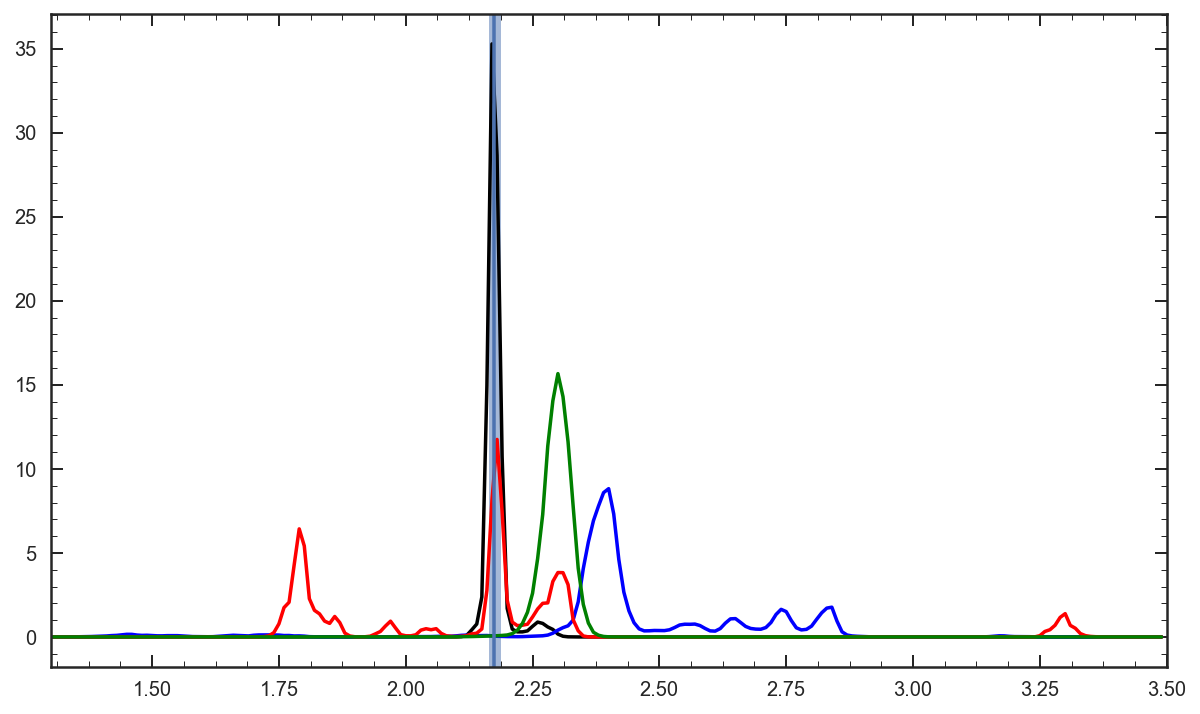

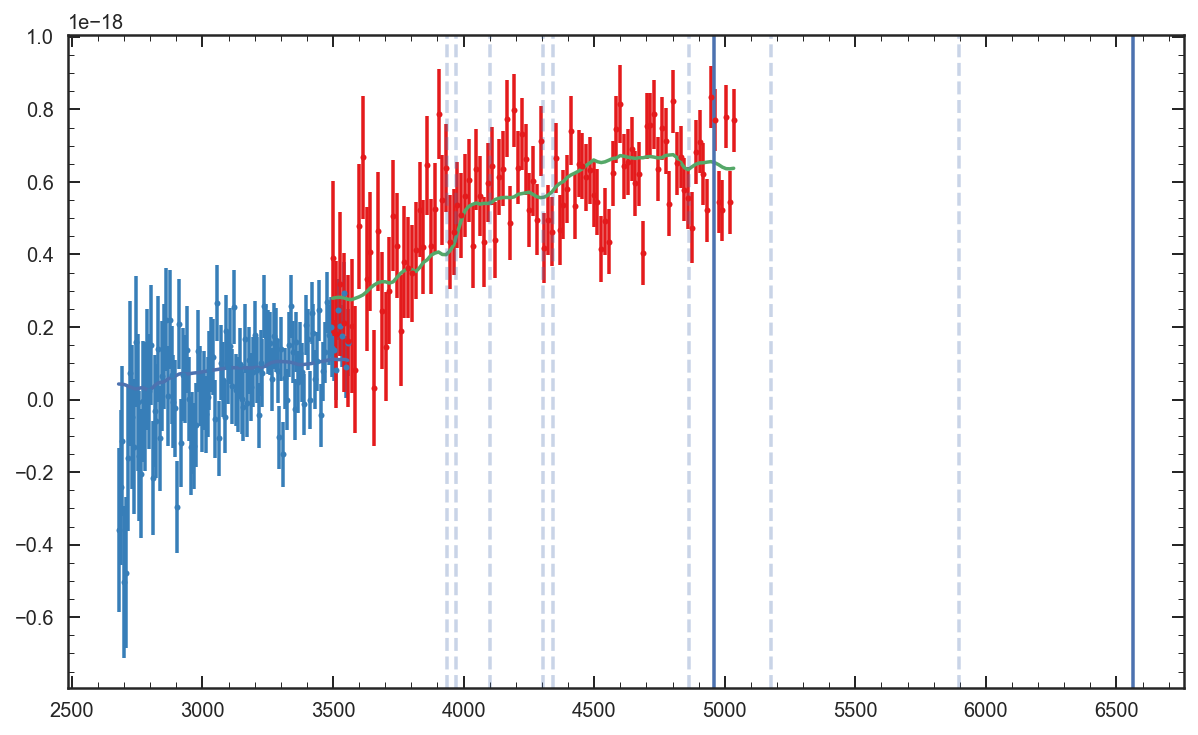

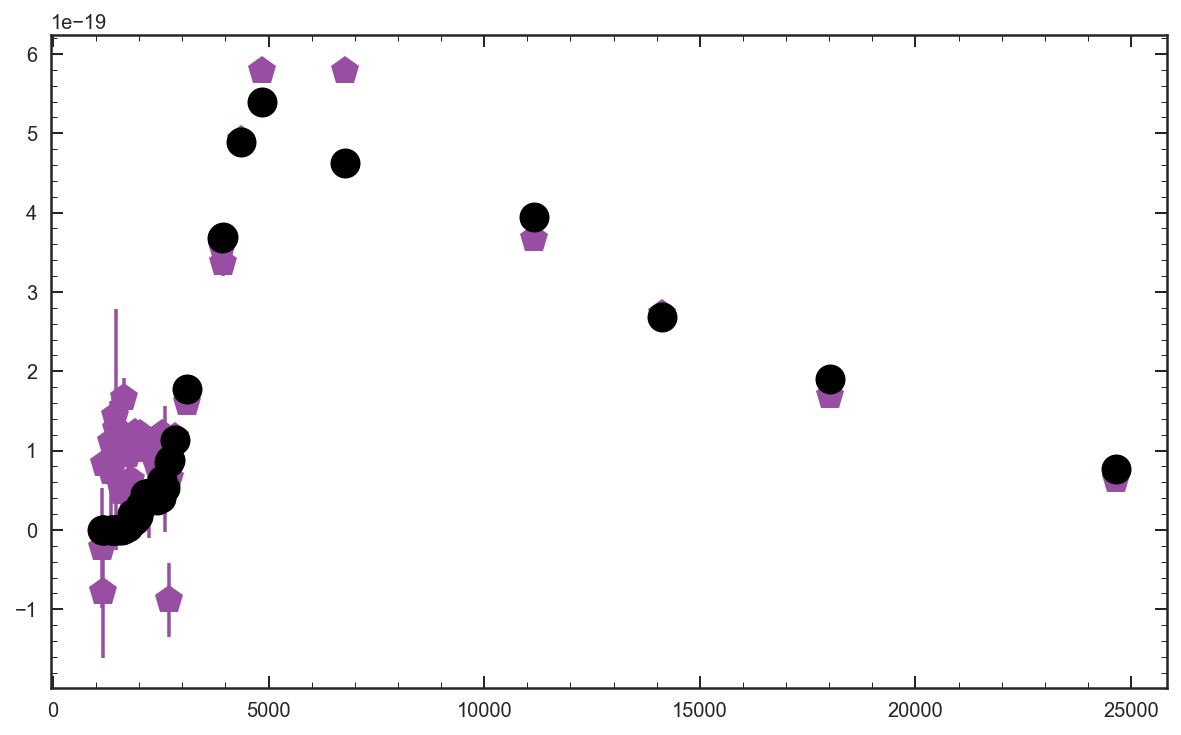

In [67]:
#24
idx = 34

z, Pz, Pzb, Pzr, Pzp = np.load('../data/posteriors/{0}_{1}_rs_lres_pos.npy'.format(galDB.field[idx], galDB.ids[idx]))

med, med_le, med_he= Median_w_Error_cont(Pz,z)

plt.figure(figsize=[10,6])
plt.plot(z,Pz,'k')
plt.plot(z,Pzb,'b')
plt.plot(z,Pzr,'r')
plt.plot(z,Pzp,'g')
plt.axvline(med)
plt.axvspan(med - med_le, med + med_he,alpha=0.5)
plt.xlim(1.3,3.5)
print(med)

zfit = z[Pz == max(Pz)][0]
zfitb = z[Pzb == max(Pzb)][0]
zfitr = z[Pzr == max(Pzr)][0]
zfitp = z[Pzp == max(Pzp)][0]

sp = Gen_spec(galDB.field[idx], galDB.ids[idx], med, glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0], g102_lims=[8500,11300] )
sp.Sim_all(0.019,1.5,0)
        
plt.figure(figsize=[10,6])
plt.errorbar(sp.Bwv_rf, sp.Bflx, sp.Berr,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(sp.Bwv_rf, sp.Bmfl)

plt.errorbar(sp.Rwv_rf, sp.Rflx, sp.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(sp.Rwv_rf, sp.Rmfl)

plt.axvline(3934.777,linestyle='--', alpha=.3)
plt.axvline(3969.588,linestyle='--', alpha=.3)
plt.axvline(4102.89,linestyle='--', alpha=.3)
plt.axvline(4305.61,linestyle='--', alpha=.3)
plt.axvline(4341.68,linestyle='--', alpha=.3)
plt.axvline(4862.68,linestyle='--', alpha=.3)
plt.axvline(5176.7,linestyle='--', alpha=.3)
plt.axvline(5895.6,linestyle='--', alpha=.3)

plt.axvline(4960)
plt.axvline(6564)

plt.figure(figsize=[10,6])
plt.errorbar(sp.Pwv_rf, sp.Pflx, sp.Perr,
                             linestyle='None', marker='p', markersize=15, color='#984ea3')
plt.plot(sp.Pwv_rf, sp.Pmfl,'ko',zorder=5,ms=15)

In [3]:
med = np.zeros(len(galDB.index))
med_le = np.zeros(len(galDB.index))
med_he = np.zeros(len(galDB.index))

for i in galDB.index:
    z, Pz, Pzb, Pzr, Pzp = np.load('../data/posteriors/{0}_{1}_rs_lres_pos.npy'.format(galDB.field[i], galDB.ids[i]))
    med[i], med_le[i], med_he[i] = Median_w_Error_cont(Pz,z)
    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


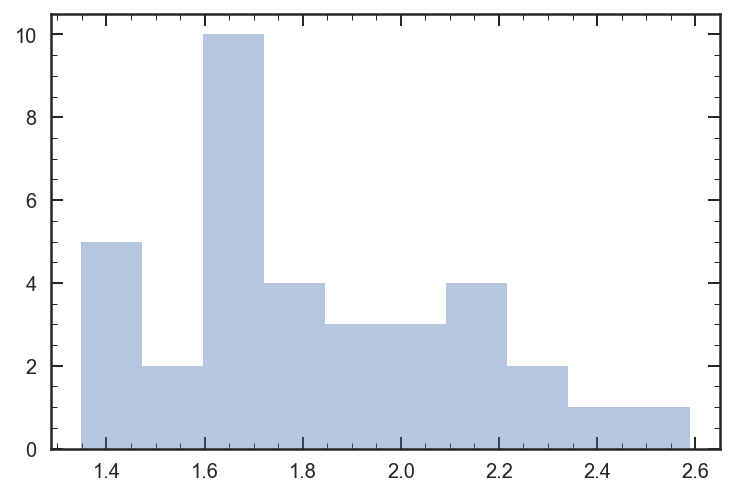

In [6]:
sea.distplot(med,kde=False,bins=10)

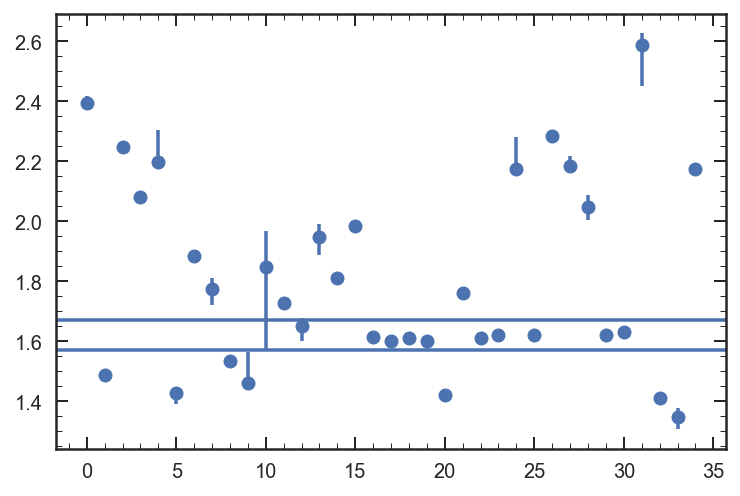

In [11]:
plt.errorbar(galDB.index,med,[med_le,med_he],fmt='o')
plt.axhline(1.57)
plt.axhline(1.67)